In [2]:
#@title
# Importação de bibliotecas necessárias
import cv2
from matplotlib import pyplot as plt
import numpy as np
import argparse
import imutils
from imutils import contours
caminho = "/content/drive/MyDrive/Mestrado/processamentoImagens/"


In [3]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
imagem = cv2.imread(caminho + 'imagens/nubank1.png')
#imagem = cv2.imread(caminho + 'imagens/cartao.png')
#imagem = cv2.imread(caminho + 'imagens/xuxa.jpg')
#imagem = cv2.imread(caminho + 'imagens/01.png')
#imagem = cv2.imread(caminho + 'imagens/credit_card_05.png')
#imagem = cv2.imread(caminho + 'imagens/inter.png')
#imagem = cv2.imread(caminho + 'imagens/err1.png')

Bandeira: Master
Número do Cartão #: 5032933437649846


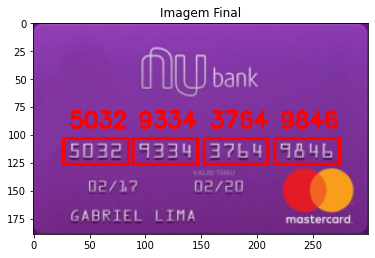

In [28]:
#@title
# Carrega a imagem do cartão para ser identificado e converte para tons de cinza
PrimeiroNumero = {"0": "zero","3": "American Express", "4": "Visa","5": "Master","6": "Discover Card","7": "Fake"}
imagem = imutils.resize(imagem, width=300)
cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
refOCR = cv2.imread(caminho +'imagens/ocr_a_reference.png')
refOCR = cv2.cvtColor(refOCR, cv2.COLOR_BGR2GRAY) # converte para escala de cinza 256 tons
refOCR = cv2.threshold(refOCR, 10, 255, cv2.THRESH_BINARY_INV)[1] # Converte para escala binária e inverte as cores
refCont = cv2.findContours(refOCR.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
refCont = imutils.grab_contours(refCont)
refCont = contours.sort_contours(refCont, method="left-to-right")[0]
digitos = {}

for (i, c) in enumerate(refCont):
    
    # extrai os dígitos dos 10 retângulos criados anteriormente
    (x, y, w, h) = cv2.boundingRect(c)
    roi = refOCR[y:y + h, x:x + w]
    roi = cv2.resize(roi, (57, 88))
    
    # Adiciona a matriz identificada e redimensionada para um dicionários com os dígitos
    digitos[i] = roi
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
tophat = cv2.morphologyEx(cinza, cv2.MORPH_TOPHAT, rectKernel)
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
contornos = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contornos = imutils.grab_contours(contornos)
localizacoes = []
# cria um loop com o array de contornos.
for (i, c) in enumerate(contornos):
    # Calcula a caixa delimitadora dos contornos criando uma caixa mantendo o aspecto
    
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)

    # a maioria dos cartões usa 4 grupos de 4 dígitos mantendo o aspecto
    if ar > 2.5 and ar < 4.0:
        # Busca altura largura e altura para os retângulos
        # and height
        if (w > 40 and w < 55) and (h > 10 and h < 20):
            # faz o append das posições largura e altura dos retângulos
            localizacoes.append((x, y, w, h))
# classifica os digitos da esquerda para a direita para ordenar
localizacoes = sorted(localizacoes, key=lambda x:x[0])
saida = []
# Faz um loop para verificação dentro da área de cada retângulo, para fazer o OCR
for (i, (gX, gY, gW, gH)) in enumerate(localizacoes):
    # inicializa uma variável
    saidaAgrupada = []

    # Seleciona na imagem em tons de cinza as cooredenadas de cada retângulo
    # após isso aplica a binarização por otsu novamente
    grupo = cinza[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    grupo = cv2.threshold(grupo, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # detecta os contornos individuais dos dígitos do grupo,
    ContornoDigito = cv2.findContours(grupo.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ContornoDigito = imutils.grab_contours(ContornoDigito)
    ContornoDigito = contours.sort_contours(ContornoDigito, method="left-to-right")[0]
    
    # Faz um loop nos caracteres detectados
    for c in ContornoDigito:
        # extrai os digitos e redimensiona para ficar no tamanho da imagem referência
        (x, y, w, h) = cv2.boundingRect(c)
        roi = grupo[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))

        # Inicializa uma lista para verificar o score de compatibilidade
        scores = []

        # faz um loop para comparar as referências e os dígitos ROI
        for (digit, digitROI) in digitos.items():
            # cria a matriz de características e compara com o score, adicionando na lista scores
            
            result = cv2.matchTemplate(roi, digitROI, cv2.TM_CCOEFF)
            
            (_, score, _, _) = cv2.minMaxLoc(result)
            
            scores.append(score)

        # Adiciona no saidaAgrupada a melhor correspondência da comparação
        saidaAgrupada.append(str(np.argmax(scores)))
        
    # desenha os retângulos em volta do grupo
    cv2.rectangle(imagem, (gX - 5, gY - 5),
        (gX + gW + 5, gY + gH + 5), (0, 0, 255), 2)
    cv2.putText(imagem, "".join(saidaAgrupada), (gX, gY - 15),
        cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)

    # Atuliza com todos os dados o saidaAgrupada
    saida.extend(saidaAgrupada)
print("Bandeira: {}".format(PrimeiroNumero[saida[0]]))
print("Número do Cartão #: {}".format("".join(saida)))

plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))
plt.title('Imagem Final'); plt.show()